In [1197]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
from collections import Counter

# Importing the dataset

In [1198]:
df = pd.read_csv('data.csv')
df.drop('Unnamed: 32', axis=1, inplace=True)

In [1199]:
print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

# Preprocessing

* Convert into numpy arrays
* Scale features
* Separate labels from features
* Split into train / test sets
* Convert to tensors

## Convert to numpy

In [1200]:
data = df.to_numpy()

## Separate labels from features

In [1201]:
labels = data[:, 1].reshape(569, 1)
train_y, test_y = labels[:284, 0], labels[284:568, 0]
data = data[:, 2:32]

## Convert letter labels into digits

In [1202]:
for i in range(len(train_y)):
        if train_y[i] == 'M':
            train_y[i] = 1
        else:
            train_y[i] = 0

for i in range(len(train_y)):
        if test_y[i] == 'M':
            test_y[i] = 1
        else:
            test_y[i] = 0

## Check out distribution of labels

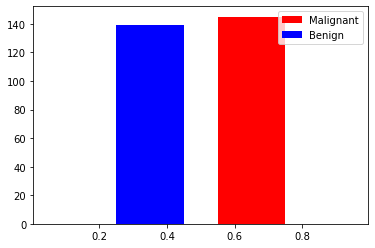

In [1203]:
l = list()
b = list()
for num in train_y:
    if num == 1:
        l.append(num)
    else:
        b.append(num)
labels = ['Malignant', 'Benign']
colors = ['red', 'blue']
plt.hist([l, b], 2, label=labels, color=colors)
plt.legend(loc='upper right')


# Convert label arrays to tensors

In [1204]:
train_y = torch.from_numpy(train_y.astype(np.float32)).reshape(train_y.shape[0], 1)
test_y = torch.from_numpy(test_y.astype(np.float32)).reshape(test_y.shape[0], 1)

# Plot data as scatterplot, with y-axis being its features summed

Text(0, 0.5, 'Sum of features')

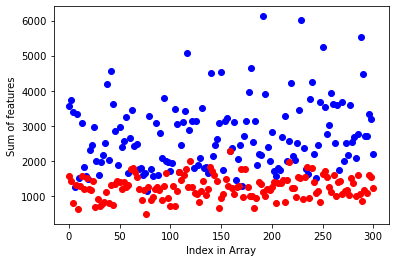

In [1205]:
m = list()
b = list()
for example, label in zip(data[:284], train_y):
    val = np.sum(example)
    if label == 1:
        m.append(val)
    else:
        b.append(val)
x = np.linspace(0, 300, len(m))
colors = ['blue']
plt.scatter(x, m, color = colors)
x = np.linspace(0, 300, len(b))
colors = ['red']
plt.scatter(x, b, color=colors)
plt.xlabel('Index in Array')
plt.ylabel('Sum of features')

## Perform feature scaling

In [1206]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

## Separate remaining features into train / test sets & convert to tensors

In [1207]:
train_feats = torch.from_numpy(data[:284].astype(np.float32))
test_feats = torch.from_numpy(data[284:568].astype(np.float32))

# Create logistic regression model to following specs:

* The only layers will be the input and output layers
* The two layers are fully connected
* Output is computed with the sigmoid function

In [1208]:
class LogisticRegression(nn.Module):
    def __init__(self, in_dim):
        super(LogisticRegression, self).__init__()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.output(x)
        y = self.sigmoid(y)
        return y

# Initialize model along with its loss function and optimizer

In [1209]:
m = LogisticRegression(30)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=.01)

# Minimize cost function to find optimal weights

In [1210]:
losses = list()
epochs = 2000
for i in range(epochs):
    output = m(train_feats)
    loss = criterion(output, train_y)
    if (i + 1) % 70 == 0:
        losses.append(loss.item())
    if (i + 1) % 100 == 0 or i == epochs - 1:
        print(f'epoch #{i}, loss: {loss}, weight: {m.output.weight}')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch #99, loss: 0.09419701248407364, weight: Parameter containing:
tensor([[ 0.4127,  0.6347,  0.5065,  0.3338,  0.1794,  0.4105,  0.2743,  0.2615,
          0.1811, -0.4893,  0.2276, -0.1836,  0.5167,  0.3557,  0.1996, -0.1986,
         -0.0976,  0.1921, -0.4503, -0.3971,  0.4472,  0.3777,  0.2735,  0.5019,
          0.3228,  0.3295,  0.2920,  0.2003,  0.5081,  0.2661]],
       requires_grad=True)
epoch #199, loss: 0.06925932317972183, weight: Parameter containing:
tensor([[ 0.5162,  0.8548,  0.6072,  0.4439,  0.2088,  0.3973,  0.3764,  0.3465,
          0.1063, -0.6633,  0.3610, -0.3309,  0.6315,  0.4910,  0.3249, -0.3947,
         -0.1013,  0.2493, -0.4953, -0.6092,  0.5835,  0.6421,  0.4028,  0.6421,
          0.4914,  0.3660,  0.4227,  0.3341,  0.7192,  0.3991]],
       requires_grad=True)
epoch #299, loss: 0.05848011374473572, weight: Parameter containing:
tensor([[ 0.5867,  0.9934,  0.6760,  0.5218,  0.2191,  0.3627,  0.4555,  0.3989,
          0.0780, -0.8043,  0.4713, -0.4748

# Plot loss through all epochs

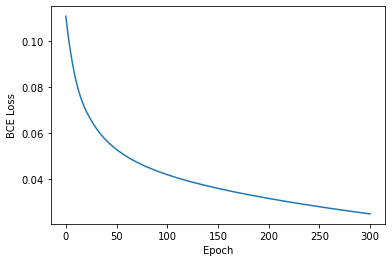

In [1211]:
from scipy.interpolate import make_interp_spline, BSpline
x = np.linspace(0, 300, 28)
y = losses
x_new = np.linspace(x.min(), x.max(), 400)
spl = make_interp_spline(x, y)
y_smooth = spl(x_new)
plt.plot(x_new, y_smooth)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.show()

# Test accuracy against test set

In [1212]:
with torch.no_grad():
    y_pred=m(test_feats)
    y_pred_class=y_pred.round()
    accuracy=((y_pred_class == test_y).sum()) / 284
    print(f'Accuracy: {round(accuracy.item() * 100, 1)}%')

Accuracy: 97.2%


# Plot decision boundary

2


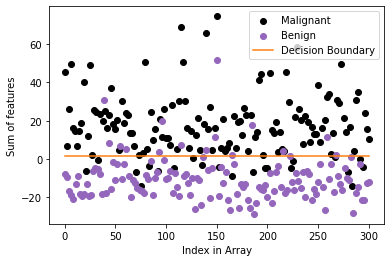

In [1213]:
s = list()
b = list()
for example, label in zip(data[:284], train_y):
    val = np.sum(example)
    if label == 1:
        s.append(val)
    else:
        b.append(val)
x = np.linspace(0, 300, len(s))
print(len(r))
colors = ['black']
plt.scatter(x, s, color = colors, label='Malignant')
x = np.linspace(0, 300, len(b))
colors = ['tab:purple']
n = (torch.sum(m.output.weight) - m.output.weight[0] + m.output.weight[0]) / 30
c = m.output.weight[0].detach().numpy()
plt.scatter(x, b, color=colors, label='Benign')
x = np.linspace(0, 300, 30)
plt.plot(x, (n.detach().numpy() + m.output.bias[0].detach().numpy()), color = 'tab:orange', label='Decision Boundary')
plt.xlabel('Index in Array')
plt.ylabel('Sum of features')
plt.legend()